<a href="https://colab.research.google.com/github/weyland-zekai-xu/tutorial/blob/main/NeuralModelling_Assignment3_Task1%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dyna planning

#### Background

The aim of this part of the assignment is to introduce you to the concept of Dyna (Sutton, 1990). By now you will have heard about model-free (MF) and model-based (MB) approaches to control. MF algorithms learn and store estimates of the state-action value function. This means that control simply involves retrieving those cached value estimates and choosing among the available actions by comparing their worth. MB control, on the other hand, involves the use of a model to calculate those values. In the RL literature this is typically known as planning. Planning has the advantage of affording behavioural flexibility, since once a change in the world is discovered the model can be updated and the values re-calculated in a way that reflects the global knowledge of the environment. By contrast, MF algorithms need many experiences to propagate the information about the change to other states.

Dyna (Sutton, 1990) is an integrated architecture which combines the merits of MF and MB approaches. Whilst interacting with the environment (i.e., being online), Dyna learns MF state-action values as well as a model of its environment (in the most general sense this involves both the transition and reward models). Whilst not interacting with the environment (i.e., being offline -- this can be in between consecutive moves or episodes, or during the equivalent of sleep in animals), Dyna uses its learnt model to additinally train the MF values. That is, the model now acts as a simulator of the environment and provides additional experiences for learning. This means that at decision time Dyna is fast to react, since it acts according to an MF policy by simply retrieving the relevant values; however, those values have been trained by a model and therefore contain some portion of the global knowledge of the environment collected so far.

One particularly critical aspect of learning is exploration, and in fact Dyna's original motivation was to improve the efficiency of exploration. You are invited to read the original paper by Sutton (1990) to familiarise yourself with the idea and the sort of problems it attempts to solve. The pdf of the paper can be found in the `papers` folder of this repository.

#### Task 1 [10 marks]

The first part of the assignment is to reproduce some of the results from the original Dyna paper (Sutton, 1990). In particular, **your task is to generate and visualise data plotted in figure 6** in that paper. You can neglect Dyna-PI and only implement Dyna-$Q$- and Dyna-$Q$+.

To make your life a little easier, and to let you jump right into the more interesting stuff, you are provided with the environment simulator located in `environment.py`, as well as a blueprint of the main code for the agent. That is, you have access to the file `agent.py` where you will find the `DynaAgent` class. This class has a method called `simulate` with the main simulation loop already implemented.

**Your task is to fill in the missing implementation** in the `agent.py` file. Thus, you are tasked to complete the following functions:
- `_policy`. This is the typical $\pi(a\mid s)$ which specifies how the agent chooses actions in any given state
- `_update_qvals`. This is the $Q$-value update rule
- `_update_experience_buffer`. This updates the agent's experience buffer from which it then samples planning updates
- `_update_action_count`. This counts the number of moves elapsed since each action has last been attempted
- `_plan`. This is the function which lets the agent plan

Once that's done you can run the code below which will hopefully reproduce the figure

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

class Env

In [ ]:
import numpy as np

class Environment:
    '''
    Environment class which specifies how the agent moves through a given maze
    '''

    def __init__(self, p):
        '''
        Initialise the class instance
        '''
        # modified
        self.num_x_states = p["num_x_states"]
        self.num_y_states = p["num_y_states"]
        self.num_actions = p["num_actions"]
        self.goal_state = p["goal_state"]
        self.reward_at_goal = p["reward_at_goal"]
        self.blocked_states = p["blocked_states"]
        self.start_state = p["start_state"]

        self.num_states = self.num_x_states * self.num_y_states # x*y


        self._generate_env_model()

        return None

    def _generate_env_model(self):

        '''
        Generate transition and reward models
        '''

        self.T = np.zeros((self.num_states, self.num_actions, self.num_states))
        self.R = np.zeros((self.num_states, self.num_actions), dtype=int)


        for s in range(self.num_states):
            for a in range(self.num_actions):

                s1, r = self._get_new_state(s, a)
                self.T[s, a, s1] += 1
                self.R[s, a] = r

        # normalise
        for s in range(self.num_states):
            for a in range(self.num_actions):
                if ~np.all(self.T[s, a, :] == 0):
                    self.T[s, a, :] /= np.sum(self.T[s, a, :])

        return None

    def _get_new_state(self, s, a):
        '''
        Returns next state and reward
        params:
            s: state
            a: action
        '''

        i, j  = self._convert_state_to_coords(s)
        s1, r = None, 0

        if i == 0: # top end
            if a == 0: # action up
                return s, r
        elif i == self.num_y_states - 1: # bottom end
            if a == 1: # action down
                return s, r
        if j == 0: # left end
            if a == 2: # move left
                return s, r
        elif j == self.num_x_states - 1: # right end
            if a == 3: # move right
                return s, r

        if a == 0: # move up
            ni, nj = i-1, j
        elif a == 1: # move down
            ni, nj = i+1, j
        elif a == 2: # move left
            ni, nj = i, j-1
        else: # move right
            ni, nj = i, j+1

        s1 = self._convert_coords_to_state(ni, nj)

        # check blocked states
        if s1 in self.blocked_states:
            return s, r

        # check if goal
        if s1 == self.goal_state:
            r = self.reward_at_goal

        return s1, r

    def _convert_state_to_coords(self, s):
        '''
        Convert state to coordinates to index the maze
        params:
            s: state
        '''

        return s//self.num_x_states, s%self.num_x_states

    def _convert_coords_to_state(self, i, j):
        '''
        Convert coordinates to state
        params:
            i: y coordinate
            j: x coordinate
        '''

        return np.arange(self.num_y_states*self.num_x_states).reshape(self.num_y_states, self.num_x_states)[i][j]



In [ ]:
import numpy as np
from scipy import stats # for gaussian noise


class DynaAgent(Environment):

    def __init__(self, alpha, gamma, epsilon):

        '''
        Initialise the agent class instance
        Input arguments:
            alpha   -- learning rate \in (0, 1]
            gamma   -- discount factor \in (0, 1)
            epsilon -- controls the influence of the exploration bonus
        '''

        self.alpha   = alpha
        self.gamma   = gamma
        self.epsilon = epsilon
        return None

    def init_env(self, env_config):

        '''
        Initialise the environment
        Input arguments:
            **env_config -- dictionary with environment parameters
        '''
        Environment.__init__(self, env_config)
        return None

    def _init_q_values(self):

        '''
        Initialise the Q-value table
        '''

        self.Q = np.zeros((self.num_states, self.num_actions))

        return None

    def _init_experience_buffer(self):

        '''
        Initialise the experience buffer
        '''

        self.experience_buffer = np.zeros((self.num_states*self.num_actions, 4), dtype=int)

        for s in range(self.num_states):
            for a in range(self.num_actions):
                self.experience_buffer[s*self.num_actions+a] = [s, a, 0, s]

        return None

    def _init_history(self):

        '''
        Initialise the history
        '''

        self.history = np.empty((0, 4), dtype=int)


        return None

    def _init_action_count(self):

        '''
        Initialise the action count
        '''

        self.action_count = np.zeros((self.num_states, self.num_actions), dtype=int)

        return None

    def _update_experience_buffer(self, s, a, r, s1): # to complete

        '''
        Update the experience buffer (world model)
        Input arguments:
            s  -- initial state
            a  -- chosen action
            r  -- received reward
            s1 -- next state
        '''

        self.experience_buffer[s*self.num_actions+a,:] = np.asarray((s,a,r,s1))
        return None

    def _update_qvals(self, s, a, r, s1, bonus=False): ## to complete

        '''
        Update the Q-value table
        Input arguments:
            s     -- initial state
            a     -- chosen action
            r     -- received reward
            s1    -- next state
            bonus -- True / False whether to use exploration bonus or not
        '''
        best_a  = np.argmax(self.Q[s1,:])
        next_Q = self.Q[s1,best_a]

        # complete the code

        self.Q[s,a] = self.Q[s,a] + self.alpha*(r + (self.epsilon*bonus*np.sqrt(self.action_count[s,a])) + self.gamma*next_Q - self.Q[s,a])

        return None

    def _update_action_count(self, s, a): # to complete

        '''
        Update the action count
        Input arguments:
            Input arguments:
            s  -- initial state
            a  -- chosen action
        '''

        self.action_count = self.action_count + 1
        self.action_count[s,a] = 0
        return None

    def _update_history(self, s, a, r, s1):

        '''
        Update the history
        Input arguments:
            s     -- initial state
            a     -- chosen action
            r     -- received reward
            s1    -- next state
        '''

        self.history = np.vstack((self.history, np.array([s, a, r, s1])))

        return None

    def _policy(self, s): # !!complete

        '''
        Agent's policy
        Input arguments:
            s -- state
        Output:
            a -- index of action to be chosen
        '''
        qs = self.Q[s,:]
        ns = self.action_count[s,:]
        adapted_qs = qs + self.epsilon*np.sqrt(ns)

        #if there is multiple adapted qs with same value, make a random choice
        # between them. Im using noise to make the values different
        # the noise doesnt change the q values itself

        if self.epsilon != 1:
            if np.unique(adapted_qs).shape[0] < 4:
                adapted_qs += np.random.randn(4) * 1e-5

            a = np.argmax(np.asarray(adapted_qs))

        # epsilon greedy:
        else:
            epsi = 0.1
            if np.random.random() < epsi:
                a = np.random.randint(0,4)
            else:
                if np.unique(qs).shape[0] < 4:
                    random_noise = np.random.randn(4) * 1e-5
                    qs += random_noise
                    a = np.argmax(np.asarray(qs))
                    qs -= random_noise
                else:
                    a = np.argmax(np.asarray(qs))

        return a
      #Your task is to fill in the missing implementation in the agent.py file. Thus, you are tasked to complete the following functions:

      # _policy. This is the typical  𝜋(𝑎∣𝑠)  which specifies how the agent chooses actions in any given state
      # _update_qvals. This is the  𝑄 -value update rule
      # _update_experience_buffer. This updates the agent's experience buffer from which it then samples planning updates
      # _update_action_count. This counts the number of moves elapsed since each action has last been attempted
      # _plan. This is the function which lets the agent plan

    def _plan(self, num_planning_updates): # to complete

        '''
        Planning computations
        Input arguments:
            num_planning_updates -- number of planning updates to execute
        '''

        for _ in range(num_planning_updates):

            sars_ind = np.random.randint(self.experience_buffer.shape[0])
            s, a, r, s1 = self.experience_buffer[sars_ind]

            self._update_qvals(s, a, r, s1, bonus=True)

        return None

    def get_performace(self):

        '''
        Returns cumulative reward collected prior to each move
        '''

        return np.cumsum(self.history[:, 2])

    def simulate(self, num_trials, reset_agent=True, num_planning_updates=None):

        '''
        Main simulation function
        Input arguments:
            num_trials           -- number of trials (i.e., moves) to simulate
            reset_agent          -- whether to reset all knowledge and begin at the start state
            num_planning_updates -- number of planning updates to execute after every move
        '''
        if reset_agent:

            self._init_q_values()
            self._init_experience_buffer()
            self._init_action_count()
            self._init_history()

            self.s = self.start_state

        for _ in range(num_trials):

            # choose action
            a  = self._policy(self.s)
            # get new state
            s1 = np.random.choice(np.arange(self.num_states), p=list(self.T[self.s, a, :]))
            # receive reward
            r  = self.R[self.s, a]
            # learning
            self._update_qvals(self.s, a, r, s1, bonus=False)
            # update world model
            self._update_experience_buffer(self.s, a, r, s1)
            # reset action count
            self._update_action_count(self.s, a)
            # update history
            self._update_history(self.s, a, r, s1)
            # plan
            if num_planning_updates is not None:
                self._plan(num_planning_updates)

            if s1 == self.goal_state:
                self.s = self.start_state
            else:
                self.s = s1

        return None




In [ ]:

dyna_qplus  = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0.001)
dyna_qminus = DynaAgent(alpha=0.5, gamma=0.9, epsilon=0)


In [ ]:
maze1_conf = {
    'num_x_states': 9,
    'num_y_states': 6,
    'num_actions': 4,
    'goal_state': 8,
    'reward_at_goal': 1,
    'start_state': 48,
    'blocked_states': [28, 29, 30, 31, 32, 33, 34, 35]
}

maze2_conf = {

    'num_x_states': 9,
    'num_y_states': 6,
    'num_actions': 4,
    'goal_state': 8,
    'reward_at_goal': 1,
    'start_state': 48,
    'blocked_states': [28, 29, 30, 31, 32, 33, 34] #  maze2 configuration
}


In [ ]:
num_trials = 3000
num_runs   = 50

perf       = [np.zeros((num_runs, num_trials*2)),np.zeros((num_runs, num_trials*2)), np.zeros((num_runs, num_trials*2))]
agents     = [dyna_qplus, dyna_qminus]

for idx_agent, agent in enumerate(agents):

    for idx_run in range(num_runs):
        agent.init_env(maze1_conf)
        agent.simulate(num_trials=num_trials, reset_agent=True, num_planning_updates=10)
        # world change
        agent.init_env(maze2_conf)
        agent.simulate(num_trials=num_trials, reset_agent=False, num_planning_updates=10)
        # save performance
        perf[idx_agent][idx_run, :] = agent.get_performace()
        if (idx_run+1)%10 == 0:
            print('done with run %u/%u'%(idx_run+1, num_runs))

# average cumulative reward
avg_perf_dyna_qplus  = np.mean(perf[0], axis=0)
avg_perf_dyna_qminus = np.mean(perf[1], axis=0)


done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50
done with run 10/50
done with run 20/50
done with run 30/50
done with run 40/50
done with run 50/50


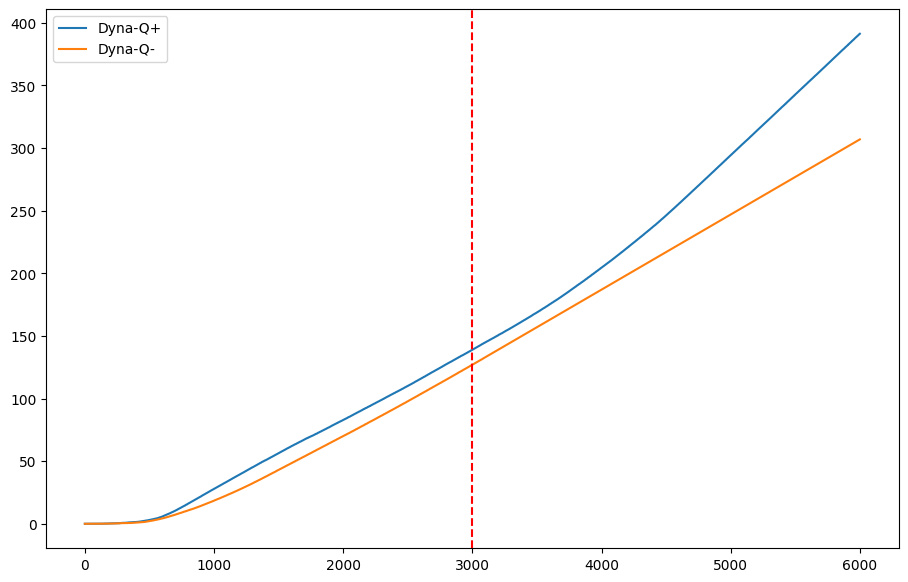

In [ ]:

plt.figure(figsize=(11, 7))
plt.plot(avg_perf_dyna_qplus,  label='Dyna-Q+')
plt.plot(avg_perf_dyna_qminus, label='Dyna-Q-')
plt.axvline(3000, linestyle='--', c='r')
plt.legend()



Describe in your own words the apparent differences you observe in the above plot. Some of those differences involve the particular choice of the exploration bonus used in this algorithm. Suggest and implement another sensible exploration bonus and compare the performance of your agent against Dyna-$Q$+ and Dyna-$Q$-. Explain your choice.

The figure shows the average performance of Dyna systems on a shortcut task: The left maze was used for the first 3000 time steps, the right maze for the last trials. Shown is the cumulative reward received by a Dyna system at each time (e.g., the slope corresponds to the rate at which reward was received).

We can observe from the plot above that the DYNA Q+ agent increase in the gaining rate of the reward (increasing gradient), while the DYNA Q- approach semms to  This means that Dyna-Q+ learns to take a shortcut, while Dyna-Q- does not. The possible explnation would be that the exploration bonus that Dyna-Q+ has and Dyna-Q- doesnt.

The DYNA Q+ system also learned the original long route faster than the Q- system. Continually re-exploring the world means occasionally making suboptimal actions. Finally, we can see that the Q+ system actually acheives a slightly lower rate of reinforcement during the first 3000 steps: in a static environment, DYNA Q+ will eventually perform worse than Dyna-Q-, whereas, in a changing environment, it will be far superior, as demonstrated in this example

## 2-step task

#### Background

The 2-step task is one of the most iconic RL tasks (Daw et al. 2011). It was designed to dissect the relative contributions of the MF and MB systems in human choices. There are multiple ways in which MB information can enter choice. For instance, as you will have seen in the case of Dyna, the MF values are additionally trained by the MB system during offline behavioural states. In fact, this process of Dyna-style planning parallels closely hippocampal replay which has been suggested to implement MB planning (Mattar \& Daw, 2018).

For the purpose of this exercise, we will assume that the choice is guided by a linear combination of the MF and MB values. Thus, by tweaking the relative contribution of each, you would expect different behaviours to emerge. Classically, the measure of this balance used in the 2-step task is stay probability. That is, the probability that the subject/agent repeats the same first-stage choice conditioned on the outcome of the second stage in the previous trial.

#### Task 2 [20 marks]

For this part of the assigniment, **your task is to reproduce and visualise data plotted in figure 2** in Daw et al. (2011). There is no pre-implemented code for the agent, except for some basics in the `agent.py` file where you can find the `TwoStepAgent` class. Therefore, you have to follow the methodology in the paper and implement it yourself. You can find the relevant paper in the `papers` folder of this git repository. The only provided code is the one below, as well as the `get_stay_probabilities` method.

SARSA


The task consists of three states (first stage: $s_A$; second stage: $s_B$ and $s_C$ ), each with two actions ( $a_A$ and $\left.a_B\right)$. The goal of both the model-based and model-free subcomponents of the algorithm is to learn a state-action value function $Q(s, a)$ mapping each state-action pair to its expected future value. On trial $t$, we denote the first-stage state (always $s_A$ ) by $s_{1, t}$, the second-stage state by $s_{2, t}$ the first- and secondstage actions by $a_{1, t}$ and $a_{2, t}$, and the first- and second-stage rewards as $r_{1, t}$ (always zero) and $r_{2, t}$.

The model free algorithm was SARSA $(\lambda)$ temporal difference learning (Rummery and Niranjan, 1994). At each stage $i$ of each trial $t$, the value for the visited state-action pair was updated according to:
$$
Q_{T D}\left(s_{i, t}, a_{i, t}\right)=Q_{T D}\left(s_{i, t}, a_{i, t}\right)+\alpha_i \delta_{i, t}
$$
where
$$
\delta_{i, t}=r_{i, t}+Q_{T D}\left(s_{i+1, t}, a_{i+1, t}\right)-Q_{T D}\left(s_{i, t}, a_{i, t}\right)
$$
and $\alpha_i$ are free learning-rate parameters. (We allow different learning rates $\alpha_1$ and $\alpha_2$ for the two task

Then, using Bellman's equation, we define the model-based values of the first level actions as
$$
Q_{M B}\left(s_A, a_j\right)=P\left(s_B \mid s_A, a_j\right) \max _{a \in\left\{a_A, a_B\right\}} Q_{T D}\left(s_B, a\right)+P\left(s_C \mid s_A, a_j\right) \max _{a \in\left\{a_A, a_B\right\}} Q_{T D}\left(s_C, a\right)
$$

In [69]:
np.ones(4) * 0.5

array([0.5, 0.5, 0.5, 0.5])

In [76]:

class TwoStepAgent:
    def __init__(self, alpha1, alpha2, beta1, beta2, lam, w, p):
        """
        Initialize the agent class instance.

        Args:
            alpha1 (float): Learning rate for the first stage.
            alpha2 (float): Learning rate for the second stage.
            beta1  (float): Inverse temperature for the first stage.
            beta2  (float): Inverse temperature for the second stage.
            lam    (float): Eligibility trace parameter.
            w      (float): Mixing weight for model-free vs. model-based learning.
            p      (float): Perseveration strength.
        """
        self.alpha1 = alpha1
        self.alpha2 = alpha2

        self.beta1 = beta1
        self.beta2 = beta2
        self.rewards = np.ones(4) * 0.5

        self.lam = lam
        self.w = w
        self.p = p
        self.num_actions = 2
        self.num_states = 3
        self.start_state = 0

        self._init_q_values()
        self._init_history()
        self._init_transition_matrix()
        self._init_track_state_transition()

    def _init_q_values(self):
        """ini Q-value tables for TD, MB, and combined strategies."""
        self.QTD = np.zeros(self.num_states * self.num_actions)
        self.QMB = np.zeros(self.num_states * self.num_actions)
        self.Qnet = np.zeros(self.num_states * self.num_actions)

    def _init_history(self):
        self.history = np.empty((0, 3), dtype=int)

    def get_reward(self, s, a):
        """
        Calculate the reward for a given state and action.

        Args:
            s (int): State (should be 1 or 2 in the current setup).
            a (int): Action (either 0 or 1).

        Returns:
            int: Reward received.
        """
        adjusted_s = max(1, min(s, 2))
        adjusted_a = max(0, min(a, 1))
        # calculate pos
        position = (adjusted_s - 1) * 2 + adjusted_a
        prob = self.rewards[position]
        return np.random.choice([0, 1], p=[1 - prob, prob])

    def update_rewards(self):
        """Update rewards by adding Gaussian noise with lower and upper bounds"""
        # self.rewards += np.random.normal(loc=0, scale=0.025, size=4)
        self.rewards += np.random.normal(loc=0, scale=0.1, size=4)
        self.rewards = np.clip(self.rewards, 0.0, 1.0)

    def _init_transition_matrix(self):
        """Initialize the transition matrix for state transitions."""
        self.transition_m = [[0.7, 0.3], [0.3, 0.7]]
        self.current_transition_m = self.transition_m[0]

    def _init_track_state_transition(self):
        """Initialize counters for tracking evidence for each transition matrix."""
        self.transition_1 = 0
        self.transition_2 = 0
        self.last_a = -1

    def _track_state_transitions(self, a, s1):
        """
        Track the state transitions to update the transition matrix evidence counters.

        Args:
            a (int): Action taken.
            s1 (int): Resulting state.
        """
        if (s1 == 1 and a == 0) or (s1 == 2 and a == 1):
            self.transition_1 += 1
        elif (s1 == 2 and a == 0) or (s1 == 1 and a == 1):
            self.transition_2 += 1

    def _update_q_td(self, s, a, r, s1, a1, trace):
        """
        Update the Q-value table for TD learning.

        Args:
            s (int): Initial state.
            a (int): Chosen action.
            r (int): Received reward.
            s1 (int): Next state.
            a1 (int): Next action.
            trace (bool)
        """
        sa_index = s * self.num_actions + a
        if s == 0:
            next_sa_index = s1 * self.num_actions + a1
            q_s1 = self.QTD[next_sa_index]

            if trace:
                delta = r - q_s1
                self.QTD[sa_index] += self.alpha1 * delta * self.lam
            else:
                q_s = self.QTD[sa_index]
                delta = r + q_s1 - q_s
                self.QTD[sa_index] += self.alpha1 * delta
        else:
            q_s = self.QTD[sa_index]
            delta = r - q_s
            self.QTD[sa_index] += self.alpha2 * delta

    def _update_q_mb(self, s, a):
        """
        Update the Q-value table for MB learning.

        Args:
            s (int): Initial state.
            a (int): Chosen action.
        """
        if self.transition_1 > self.transition_2:
            self.current_transition_m = self.transition_m[0]
        else:
            self.current_transition_m = self.transition_m[1]

        sa_index = s * self.num_actions + a
        if s == 0:
            self.QMB[sa_index] = self.current_transition_m[a] * np.max(self.QTD[2:4]) + (1 - self.current_transition_m[a]) * np.max(self.QTD[4:])
        else:
            self.QMB[sa_index] = self.QTD[sa_index]

    def _update_q_net(self, s, a):
        """
        Update the Q-value table for the combined strategy (TD and MB).
        Args:
            s (int): State.
            a (int): Action.
        """
        sa_index = s * self.num_actions + a
        if s == 0:
            self.Qnet[sa_index] = self.w * self.QMB[sa_index] + (1 - self.w) * self.QTD[sa_index]
        else:
            self.Qnet[sa_index] = self.QTD[sa_index]

    def _update_history(self, a, s1, r):
        """
        Update the history with the latest action, state, and reward.

        Args:
            a (int): Action taken.
            s1 (int): Resulting state.
            r (int): Received reward.
        """
        self.history = np.vstack((self.history, np.array([a, s1, r])))

    def get_next_state(self, s, a):
        """
        Get the next state based on the current state and action.

        Args:
            s (int): Current state.
            a (int): Action taken.

        Returns:
            int: Next state.
        """
        if s == 0:
            prob1 = self.transition_m[0][a]
            return np.random.choice([1, 2], p=[prob1, 1 - prob1])
        else:
            return 3

    def _policy(self, s):
        """
        Define the agent's policy: action selection strategy based on the state.

        Args:
            s (int): Current state.

        Returns:
            int: Chosen action.
        """
        # Calculate the exponential of the action values (adjusted by the beta parameter)
        exp_values = np.exp([self.beta1 if s == 0 else self.beta2] * (self.Qnet[s * self.num_actions:(s + 1) * self.num_actions] + self.p * (self.last_a == np.arange(self.num_actions))))

        # Normalize to get probabilities
        action_probabilities = exp_values / np.sum(exp_values)

        # Choose an action based on the calculated probabilities
        return np.random.choice(self.num_actions, p=action_probabilities)

    def get_stay_probabilities(self):

        '''
        Calculate stay probabilities
        '''

        common_r      = 0
        num_common_r  = 0
        common_nr     = 0
        num_common_nr = 0
        rare_r        = 0
        num_rare_r    = 0
        rare_nr       = 0
        num_rare_nr   = 0

        num_trials = self.history.shape[0]
        for idx_trial in range(num_trials-1):
            a, s1, r1 = self.history[idx_trial, :]
            a_next    = self.history[idx_trial+1, 0]

            # common
            if (a == 0 and s1 == 1) or (a == 1 and s1 == 2):
                # rewarded
                if r1 == 1:
                    if a == a_next:
                        common_r += 1
                    num_common_r += 1
                else:
                    if a == a_next:
                        common_nr += 1
                    num_common_nr += 1
            else:
                if r1 == 1:
                    if a == a_next:
                        rare_r += 1
                    num_rare_r += 1
                else:
                    if a == a_next:
                        rare_nr += 1
                    num_rare_nr += 1

        return np.array([common_r/num_common_r, rare_r/num_rare_r, common_nr/num_common_nr, rare_nr/num_rare_nr])


    def simulate(self, num_trials):

        '''
        Main simulation function
        Input arguments:
            num_trials -- number of trials to simulate
        '''

        self._init_q_values()
        self._init_track_state_transition()
        self._init_history()
        self._init_transition_matrix()

        self.rewards = np.ones(4) * 0.5

        for trial in range(num_trials):

            s1 = self.start_state
            a1 = self._policy(s1)
            r1 = 0

            # next state and action
            s2 = self.get_next_state(s1, a1)

            self._track_state_transitions(a1, s2)
            self.last_a = a1
            a2 = self._policy(s2)

            r2 = self.get_reward(s2,a2)

            # Update Q tables

            self._update_q_td(s1, a1, r1, s2, a2, False)
            self._update_q_td(s2, a2, r2, None, None, False)
            self._update_q_td(s1, a1, r2, s2, a2, True)

            self._update_q_mb(s1,a1)
            self._update_q_mb(s2,a2)

            self._update_q_net(s1,a1)
            self._update_q_net(s2,a2)

            self._update_history(a1, s2, r2)
            self.update_rewards()

        return None




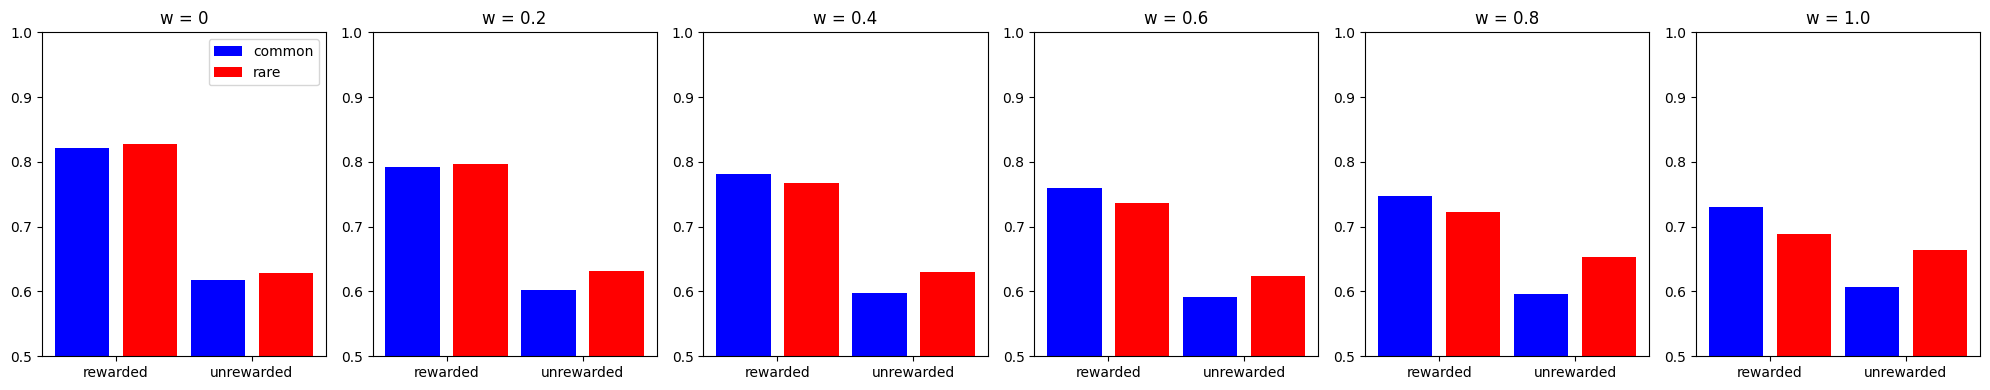

In [ ]:

def plot_stay_probabilities(stay_probas, w, subplot_index, num_plots):
    plt.subplot(1, num_plots, subplot_index)
    plt.bar(1, np.mean(stay_probas[:, 0]), facecolor='blue', label='common')
    plt.bar(2, np.mean(stay_probas[:, 1]), facecolor='red', label='rare')
    plt.bar(3, np.mean(stay_probas[:, 2]), facecolor='blue')
    plt.bar(4, np.mean(stay_probas[:, 3]), facecolor='red')
    plt.ylim(0.5, 1)
    plt.xticks([1.5, 3.5], ['rewarded', 'unrewarded'])
    plt.title(f'w = {w}')
    if subplot_index == 1:
        plt.legend()
    plt.tight_layout()

w_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
num_plots = len(w_values)


plt.figure(figsize=(20, 4))


for i, w in enumerate(w_values, start=1):
    agent = TwoStepAgent(alpha1=0.6, alpha2=0.31, beta1=4.19, beta2=2.69, lam=0.57, w=w, p=0.11)
    # agent = TwoStepAgent(alpha1=0.54, alpha2=0.42, beta1=5.19, beta2=3.69, lam=0.57, w=w, p=0.11)
    np.random.seed(2)
    num_trials = 201
    num_averg = 17
    stay_probas = np.zeros((num_averg, 4))

    for n in range(num_averg):
        agent.simulate(num_trials)
        stay_probas[n, :] = agent.get_stay_probabilities()

    plot_stay_probabilities(stay_probas, w, i, num_plots)

plt.show()

The first subplot, we can see that for both common and rare, staying probs are nearly the same, This is mainly because Model-Free agents learn and make decisions based on a cached value of actions, determined through past rewards and punishments. They rely on a strategy that does not account for the structure of the environment or the potential future consequences of actions.

For the later plots (w close to 1.0), we can observe that the agent are more likely to stay for unrewarded choice, given 'rare', vice versa for the rewarded. The MB strategy suggests that a rare transition should be informative, affecting the valuation of the other first-stage option and leading to a different pattern of stay probabilities. Specifically, it predicts that the stay probability should be higher in the case of a rare transition followed by a reward (since it suggests the unchosen option is devalued) and lower when a rare transition is unrewarded (since the unchosen option is likely better).



The data (Figure C in the paper) indicates a combination of both MF and MB strategies.

